In [1]:
import numpy as np
import torch
import scipy
import random
import matplotlib.pyplot as plt

In [2]:
# wavenumber and wavelength
k = 2.0 * np.pi
lamb =  2.0 * np.pi / k

# domain [la,lb]
la = -8.0 * lamb
lb = 8.0 * lamb

# define the mesh for observation
N_obs = 240
h_obs = (lb - la) / N_obs
mesh_obs = np.linspace(la, lb, (N_obs + 1))

mesh_mid_obs = np.zeros(N_obs + 1)

mesh_mid_obs[0] = la

for od in range(N_obs):
    mesh_mid_obs[od + 1] = (mesh_obs[od] + mesh_obs[od+1])/2.0

# transform numpy mesh to torch mesh
x_mid_obs = torch.tensor(mesh_mid_obs, dtype = torch.float32, requires_grad = True)
x_mesh_obs = torch.tensor(mesh_obs, dtype = torch.float32, requires_grad = True)

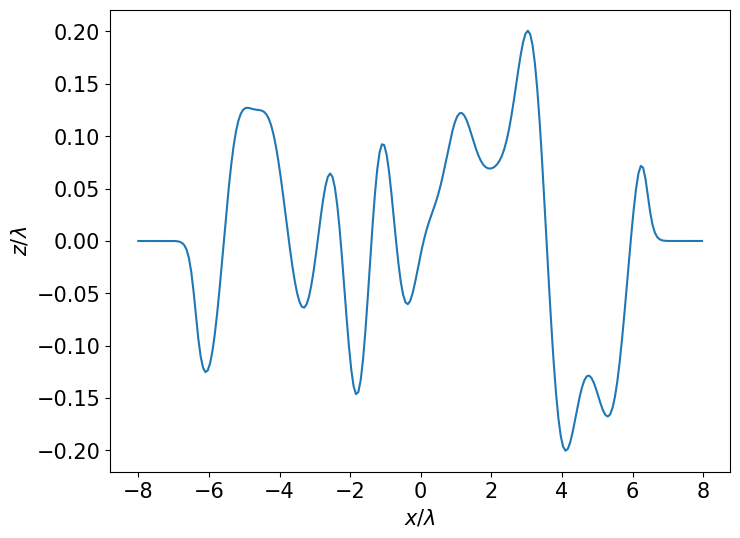

In [21]:
# Generate a random rough surface

def generate_surface():
    '''this function generates a scaled and tappered Gaussian type rough surface'''
    
    # define the a.c.f. rho(xi)
    def rho(xi):
        lamb_surface = lamb / 1.5
        insf = -(xi ** 2) / (lamb_surface ** 2)
        return np.exp(insf)

    # the following code generates a random rough surface w.r.t. the a.c.f rho
    def fft(xi,mu):
        return 2.0 / np.pi * rho(xi) * np.cos(xi * mu)

    Nh = 50
    muend = 6
    deltamu = muend / Nh
    mu_vec = np.linspace(deltamu, muend, Nh)
    integralB = np.zeros(Nh)
    integralA = np.zeros(Nh)

    for it in range(Nh):
        def fg(xi):
            return fft(xi,mu_vec[it])
        integralB[it] = scipy.integrate.quad(fg,-scipy.inf,scipy.inf)[0]
        integralA[it] = np.sqrt(integralB[it])
        
    fai = np.zeros(Nh)
    for ii in range(Nh):
        fai[ii] = 2.0 * np.pi * random.random()

    # original surface height
    def hei_ori(x):
        sumn = 0.0
        for js in range(Nh):
            sumn = sumn + integralA[js] * np.sin(mu_vec[js] * x + fai[js])
        return np.sqrt(deltamu) * sumn 
    
    # derivative of original surface
    def heid_ori(x):
        sumn2 = 0.0
        for js in range(Nh):
            sumn2 = sumn2 + integralA[js] * mu_vec[js] * np.cos(mu_vec[js] * x + fai[js])
        return np.sqrt(deltamu) * sumn2 
    
    # second order derivative of original surface
    def heidd_ori(x):
        sumn3 = 0.0
        for js in range(Nh):
            sumn3 = sumn3 - integralA[js] * mu_vec[js] * mu_vec[js] * np.sin(mu_vec[js] * x + fai[js])
        return np.sqrt(deltamu) * sumn3 

    # scale surface, set surface height in [hmin, hmax]
    function_values = hei_ori(mesh_obs)
    fmax = np.max(function_values)
    fmin = np.min(function_values)
    hmax = 0.2 * lamb
    hmin = -0.2 * lamb
    
    # scaled rough surface
    def hei_surface(x):
        return (hmax - hmin) * (hei_ori(x) - fmin) / (fmax - fmin) + hmin
    
    # derivative of scaled surface
    def heid_surface(x):
        return (hmax - hmin) * heid_ori(x) / (fmax - fmin)
    
    # second order derivative of scaled surface
    def heidd_surface(x):
        return (hmax - hmin) * heidd_ori(x) / (fmax - fmin)
    
    # tappering the surface to zero close boundaries
    a_tape = 0.8 * la
    b_tape = 0.8 * lb
    factor_tape = 5
    
    def function_tapper(x):
        tapper_left = 0.5 * (np.tanh(factor_tape * (x - a_tape)) + 1.0)
        tapper_right = 0.5 * (np.tanh(factor_tape * (b_tape - x)) + 1.0)
        return tapper_left * tapper_right
    
    # tappered surface
    def surface_tapper(x):
        return hei_surface(x) * function_tapper(x)
    
    hei_vec = surface_tapper(mesh_mid_obs)
    
    def sech(xs):
        return 1.0 / np.cosh(xs)

    def derivative_function_tapper(x):
        tapper_left = 0.5 * (np.tanh(factor_tape * (x - a_tape)) + 1.0)
        der_left = 0.5 * factor_tape * (sech(factor_tape * (x - a_tape))) ** 2
        tapper_right = 0.5 * (np.tanh(factor_tape * (b_tape - x)) + 1.0)
        der_right = -0.5 * factor_tape * (sech(factor_tape * (b_tape - x))) ** 2
        return der_left * tapper_right + der_right * tapper_left
    
    # derivative of tappered surface
    def derivative_surface_tapper(x):
        return hei_surface(x) * derivative_function_tapper(x) + heid_surface(x) * function_tapper(x) 
    
    heid_vec = derivative_surface_tapper(mesh_mid_obs)
    
    def second_der_function_tapper(x):
        tapper_left = 0.5 * (np.tanh(factor_tape * (x - a_tape)) + 1.0)
        der_left = 0.5 * factor_tape * (sech(factor_tape * (x - a_tape))) ** 2
        dder_left = - (factor_tape ** 2) * (sech(factor_tape * (x - a_tape))) ** 2 \
                * np.tanh(factor_tape * (x - a_tape))
        tapper_right = 0.5 * (np.tanh(factor_tape * (b_tape - x)) + 1.0)
        der_right = -0.5 * factor_tape * (sech(factor_tape * (b_tape - x))) ** 2
        dder_right = - (factor_tape ** 2) * (sech(factor_tape * (b_tape - x))) ** 2 \
                    * np.tanh(factor_tape * (b_tape - x))
        return dder_left * tapper_right + der_left * der_right + der_left * der_right + tapper_left * dder_right
        
    # second order derivative of tappered surface
    def second_der_surface_tapper(x):
        return heid_surface(x) * derivative_function_tapper(x) + hei_surface(x) * second_der_function_tapper(x) \
                + heidd_surface(x) * function_tapper(x)  + heid_surface(x) * derivative_function_tapper(x)
        
    heidd_vec = second_der_surface_tapper(mesh_mid_obs)
    
    return hei_vec, heid_vec, heidd_vec

hei_surface_true, heid_surface_true, heidd_surface_true = generate_surface()

# plot the random rough surface in the wavelength scale
plt.figure(figsize=[8, 6])
plt.plot(mesh_mid_obs / lamb, hei_surface_true / lamb)
plt.xlabel(r'$x/{\lambda}$', fontsize = 15)
plt.ylabel(r'$z/{\lambda}$', fontsize = 15)
plt.gca().tick_params(labelsize=15)
plt.show()

# transform numpy arrays to torch tensors
hei_surface_true_torch = torch.tensor(hei_surface_true, dtype = torch.float32, requires_grad = True)
heid_surface_true_torch = torch.tensor(heid_surface_true, dtype = torch.float32, requires_grad = True)
heidd_surface_true_torch = torch.tensor(heidd_surface_true, dtype = torch.float32, requires_grad = True)

# save the actual surface
torch.save(hei_surface_true_torch, 'vector_true_surface.pt')

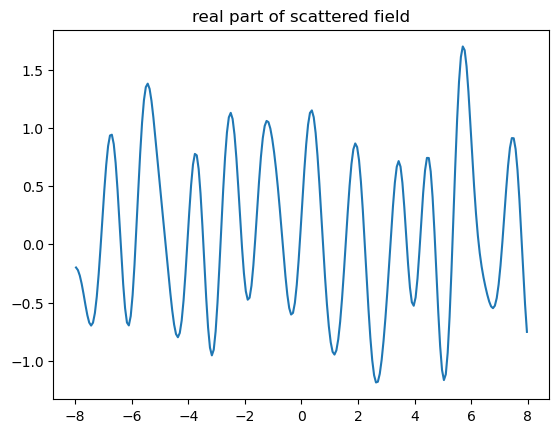

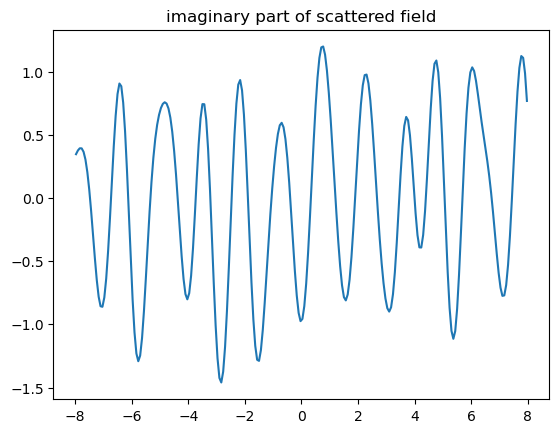

In [22]:
# angle of grazing
alpha = torch.tensor([[-1.0 * np.pi / 4.0]])

# the incident wave, which is a plane wave
def inc_field(x, z):
    g = torch.cos(alpha) * x + torch.sin(alpha) * z
    return torch.exp(1.0 * 1j * k * g)

# observation height 
zp = lamb * 0.4

# Hankel function of zeroth order of first kind
def hankel(sth):
        return torch.special.bessel_j0(sth) + 1j * torch.special.bessel_y0(sth)

# method of moments
def MOM(x_mid, hei_vec, heid_vec):
    ''' This function implements the method of moments.
     x_mid is the mesh points.
     hei_vec is the torch tensor for the surface height.
     heid_vec is the torch tensor of the derivative of surface height.
     it reaturns the torch tensor of scattered field.'''
    
    h = x_mid[100] - x_mid[99]
    N = x_mid.numel() - 1
    
    # aseemble surface incident field
    inc_vec =  torch.zeros(N, dtype=torch.cfloat)
    for i in range(N):
        inc_vec[i] = inc_field(x_mid[i+1], hei_vec[i+1])
    
    # aseemble matrix A
    A =  torch.zeros((N, N), dtype=torch.cfloat)
    
    # off-diagonal terms
    def getA_offdiag1(nn):
        ll = torch.arange(1, nn)
        ptl = 1.0 * k * torch.sqrt((x_mid[nn] - x_mid[ll]) ** 2 + (hei_vec[nn] - hei_vec[ll])**2)
        sd = torch.sqrt(1.0 + heid_vec[ll]**2)
        return 1.0 * h * 1j / 4.0 * hankel(ptl) * sd 
    def getA_offdiag2(nn):
        ll = torch.arange(nn + 1, N + 1)
        ptl = 1.0 * k * torch.sqrt((x_mid[nn] - x_mid[ll]) ** 2 + (hei_vec[nn] - hei_vec[ll])**2)
        sd = torch.sqrt(1.0 + heid_vec[ll]**2)
        return 1.0 * h * 1j / 4.0 * hankel(ptl) * sd 
    
    # diagonal term
    def getA_diag(nn):
        gamma = 0.5772156649
        term1 = 1.0 * 1j / 4.0 * h * (1.0 + 2.0 * 1j / torch.pi * gamma) 
        sd = torch.sqrt(1.0 + heid_vec[nn]**2)
        term2 = - (1.0 * h) / (2.0 * torch.pi) * (torch.log(k * sd * h / 4.0) - 1.0)
        return (term1 + term2) * sd
    
    # assemble matrix A
    for nu in range(N):
        A[nu, 0:nu] = getA_offdiag1(nu + 1)
        A[nu, nu+1:N] = getA_offdiag2(nu + 1)
        A[nu, nu] = getA_diag(nu + 1)
    
    # solve for surface current
    phid = torch.linalg.solve(A, inc_vec)
    
    zz = torch.tensor([zp])
    
    # assemble matrix B
    B =  torch.zeros((N, N), dtype=torch.cfloat)
    
    # components of matrix B
    def getB(nn):
        rr = torch.arange(1, N + 1) 
        ptl = 1.0 * k * torch.sqrt((x_mid[nn] - x_mid[rr]) ** 2 + (zz - hei_vec[rr])**2)
        sd = torch.sqrt(1.0 + heid_vec[rr]**2)
        return - 1.0 * h * 1j / 4.0 * hankel(ptl) * sd 
    
    for nd in range(N):
        B[nd, 0:N] = getB(nd + 1)

    # calculate scattered field
    phis = torch.matmul(B, phid)
    return phis


# use MOM to obtain full scattered field
phis_obs_torch = MOM(x_mid_obs, hei_surface_true_torch, heid_surface_true_torch)

# plot the real and imaginary parts and amplitude of scattered fields
mesh_plot_obs = np.delete(mesh_mid_obs, [0])
phis_obs_real_torch = phis_obs_torch.real
phis_obs_imag_torch = phis_obs_torch.imag
phis_obs_abs_torch = torch.abs(phis_obs_torch)

plt.title('real part of scattered field')
plt.plot(mesh_plot_obs / lamb, phis_obs_real_torch.detach().numpy())
plt.show()

plt.title('imaginary part of scattered field')
plt.plot(mesh_plot_obs / lamb, phis_obs_imag_torch.detach().numpy())
plt.show()

# plt.title('amplitude of scattered field')
# plt.plot(mesh_plot_obs / lamb, phis_obs_abs_torch.detach().numpy())
# plt.show()

In [23]:
# interpolate the scattered field to a any mesh set

phis_obs_numpy = phis_obs_torch.detach().numpy()
mesh_mid_ori = np.delete(mesh_mid_obs, [0])

def interpolate(N, phis_obs): 
    ''' This function interpolates the scattered data,
    and produces a list of torch tensors of scattered field.
    N means N_inverse for the maximum number of testing points.
    phis_obs is the observed scattered feild data.
    output data_phis is a list, the i-th component is the 
    interpolated scattered data with size (N_observe + i).'''
    
    def generate_mesh(Nuse):
        x_mesh = np.linspace(la,lb, Nuse+1)
        x_train = np.zeros(Nuse + 1)
        x_train[0] = la
        for od in range(Nuse):
            x_train[od + 1] = (x_mesh[od] + x_mesh[od+1])/2.0
        x_train = np.delete(x_train,[0])
        return x_train

    def gen_phis(Nuse):
        x_inverse = generate_mesh(Nuse)
        phis_data = np.interp(x_inverse, mesh_mid_ori, phis_obs)
        return torch.tensor(phis_data, dtype = torch.cfloat, requires_grad = True)
    
    data_phis = []
    for nuse in range(N_obs, N + 1):
        new_phis = gen_phis(nuse)
        data_phis.append(new_phis)
        
    return data_phis

# maximum number of testing points
N_inv  = 480

# interpolation of scattered data
data_scattered_field = interpolate(N_inv, phis_obs_numpy)

# save the data list of all the interpolated data
torch.save(data_scattered_field, 'data_scattered_field_without_noise.pt')


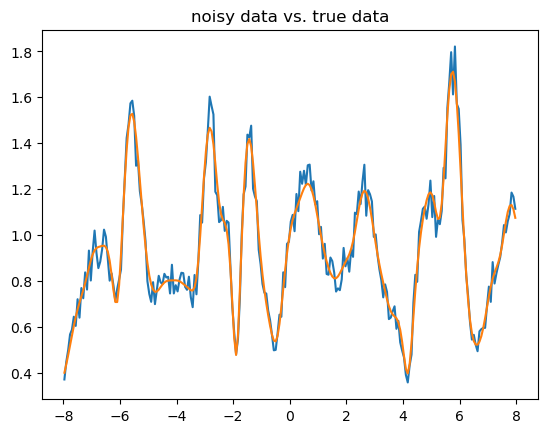

In [24]:
# noise level
epsilon = 0.10

# add Guassian noise to the scattered data
phis_noise_torch = torch.zeros(N_obs, dtype=torch.cfloat)
for i in range(N_obs):
    random_float = 2.0 * torch.rand(1) - 1.0
    phis_noise_torch[i] = phis_obs_torch[i] * (1.0 + epsilon * random_float)
    
# plot the noisy data
phis_noise_abs_torch = torch.abs(phis_noise_torch)
plt.title('noisy data vs. true data')
plt.plot(mesh_mid_ori / lamb, phis_noise_abs_torch.detach().numpy())
plt.plot(mesh_mid_ori / lamb, phis_obs_abs_torch.detach().numpy())
plt.show()

# interpolate the noisy data by the interpolate function
data_scattered_noise = interpolate(N_inv, phis_noise_torch.detach().numpy())

# save the data list of all the interpolated noisy data
torch.save(data_scattered_noise, 'data_scattered_field_with_noise.pt')